### **File Handling**

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!kill -9 -1


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [59]:
!ls drive/elisra_dl_course_project

CNN(32-64)-FC(2048-2048-1) -700-Augmentation_20.8.h5  my_model2.h5
cnn-fcc-regression.h5				      my_model3.h5
data_manipulation.py				      my_model.h5
FC-regression-augmentation_19.8.h5		      python.py
FC-regression-augmentation_20.8.h5		      test data
FC-regression-augmentation_FC#2_1.h5		      test.py
FC-regression-augmentation_FC#2_2.h5		      train
FC-regression-augmentation_FC#3_1.h5		      train data
FC-regression-augmentation_FC#3_2.h5		      x_test_aug11.npy
FC-regression-augmentation_FC#4_1.h5		      x_train_aug11.npy
FC-regression-augmentation_FC#5_1.h5		      x_val_aug11.npy
FC-regression-augmentation_FC#5_2.h5		      y_test_aug11.npy
FC-regression-augmentation_FC#6_1.h5		      y_train_aug11.npy
FC-regression-augmentation_FC#7_1.h5		      y_val_aug11.npy


In [0]:
!pip install scikit-image

In [0]:
!pip install --upgrade tensorflow-gpu==1.4

### **Training**

In [0]:
import matplotlib.pyplot as plt
import random
import numpy as np
# from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import keras
import tensorflow as tf



def unpickle(pickled):
    # This function unpickles tha files into dictionaries / arrays.

    import pickle
    with open(pickled, 'rb') as fo:
        file = pickle.load(fo)
        fo.close()
    return file


def plot_image(an_image):
    plt.figure()
    plt.imshow(an_image)
    plt.colorbar()
    plt.show(block=True)


# TODO completing the images in the train set to find min-max values
def image_completion(image_set):
    array = np.array(image_set['x_data'])
    cnt = 0
    for i in range(0, array.shape[0]):
        array[i][15][15] = image_set['y_data'][i]
        cnt+=1
    return array


  
# def root_mean_squared_error(y_true, y_pred):
#     return np.abs(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))


  
def data_augmentation(full_image_array, augment_size):
    '''TODO this function takes the original full_image_array, and separates it into different image parts.
    TODO original full_image_array size is (10000, 31, 31, 1).
    TODO the output of the function is a  new, longer x_train, y_train, made by smaller images from the train set. '''

    from sklearn.feature_extraction import image
    patches = image.extract_patches_2d(full_image_array[0], (augment_size, augment_size))
    cnt = 0
    for index in range(600):
        patch = image.extract_patches_2d(full_image_array[index], (augment_size, augment_size))
        patches = np.concatenate((patches, patch), axis=0)
    #TODO creating new x_train, y_train
    x_new_train = patches
    center = int((augmentation_size-1)/2)
    y_train = np.array((x_new_train[0][center][center]))
    x_new_train[0][center][center] = 0

    for index in range(1, x_new_train.shape[0]):
        y_train = np.append(y_train, x_new_train[index][center][center])
        x_new_train[index][center][center] = 0

    y_train = np.expand_dims(y_train, 1)
    x_train = x_new_train.reshape(x_new_train.shape[0], augmentation_size, augmentation_size, 1)
    # final_x = np.empty_like(x_train)
    # final_y = np.empty_like(y_train)
    # 
    # rand_images = np.random.choice(range(x_train.shape[0]), 10, replace=False)
    # 
    # for i in range(len(rand_images)):
    #     final_x[i] = x_train[int(rand_images[i])]
    #     final_y[i] = y_train[int(rand_images[i])]
    #TODO remember: crop the test images!!
    return x_train, y_train


def smoothL1(y_true, y_pred):
    HUBER_DELTA = 0.5
    x = K.abs(y_true - y_pred)
    if K._BACKEND == 'tensorflow':
        import tensorflow as tf
        x = tf.where(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
        return K.sum(x)

      
def data_normalization(x, min, max):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (31, 31, 3)
    : return: Numpy array of normalized data
    """
    #[-1, 1] normalization (did work, but the return back did not)
    #return np.array(2*((x - min) / (max - min)) -1)
    
    #[0,1] normalization:
    return np.array((x - min) / (max - min))

  
def data_set():
  # Training set includes a dict with x-data and the y-data
  train_set1 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver1.pickle')
  train_set2 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver2.pickle')
  train_set3 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver3.pickle')
  train_set4 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver4.pickle')
  train_set5 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver5.pickle')
  train_set6 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver6.pickle')
  train_set7 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver7.pickle')
  train_set8 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver8.pickle')
  train_set9 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver9.pickle')
  train_set10 = unpickle('drive/elisra_dl_course_project/train data/train_data_1000_31X31_ver10.pickle')

  train_set = {'x_data': [], 'y_data':[]}
  train_set['x_data'].extend(train_set1['x_data'])
  train_set['y_data'].extend(train_set1['y_data'])
  train_set['x_data'].extend(train_set2['x_data'])
  train_set['y_data'].extend(train_set2['y_data'])
  train_set['x_data'].extend(train_set3['x_data'])
  train_set['y_data'].extend(train_set3['y_data'])
  train_set['x_data'].extend(train_set4['x_data'])
  train_set['y_data'].extend(train_set4['y_data'])
  train_set['x_data'].extend(train_set5['x_data'])
  train_set['y_data'].extend(train_set5['y_data'])
  train_set['x_data'].extend(train_set6['x_data'])
  train_set['y_data'].extend(train_set6['y_data'])
  train_set['x_data'].extend(train_set7['x_data'])
  train_set['y_data'].extend(train_set7['y_data'])
  train_set['x_data'].extend(train_set8['x_data'])
  train_set['y_data'].extend(train_set8['y_data'])
  train_set['x_data'].extend(train_set9['x_data'])
  train_set['y_data'].extend(train_set9['y_data'])
  train_set['x_data'].extend(train_set10['x_data'])
  train_set['y_data'].extend(train_set10['y_data'])

  train_set['x_data'] = np.array(train_set['x_data'])
  train_set['y_data'] = np.array(train_set['y_data'])

  del(train_set1, train_set2, train_set3, train_set4, train_set5, train_set6, train_set7, train_set8, train_set9, train_set10)
  return train_set


train_set = data_set()

full_image_array = image_completion(train_set)
full_image_array = full_image_array.astype(int)


minval = np.min(np.min(np.where(full_image_array==0, full_image_array.max(), full_image_array), axis=1))

maxval = np.max(np.max(np.where(full_image_array==0, full_image_array.min(), full_image_array), axis=1))

print(full_image_array.shape)

norm_x = data_normalization(full_image_array, minval, maxval)

# print(max,min)
# img_x, img_y = 31, 31
augmentation_size = 11

batch_size = 64
epochs = 100

def input_handling_and_saving():
  (x_train, y_train) = data_augmentation(norm_x, augmentation_size)

  # plot_image(np.squeeze(full_image_array[1]))

  # plot_image(np.reshape(norm_x[1], (31,31)))


  # input image dimensions
  img_x, img_y = augmentation_size, augmentation_size
  input_size = img_x*img_y
  # (x_train, y_train) = (train_set['x_data'], train_set['y_data'])
  # print('\nxtrain shape, ytrain shape:\n', x_train.shape, y_train.shape)


  #TODO do data augmentation for the train images before train-test split

  # TODO TRAIN >>>> TEST SPLIT:
  from sklearn.model_selection import train_test_split
  # define the target variable (dependent variable) as y

  X_sptrain, X_sptest, y_sptrain, y_sptest = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  # print (X_sptrain.shape, y_sptrain.shape)
  # print (X_sptest.shape, y_sptest.shape)
  # print(X_sptrain[0])
  # print(y_train[1][0])

  #TODO TEST SET:
  y_test = y_sptest
  x_test = X_sptest

  # TODO TRAIN -VAL SPLIT
  X_sptrain2, X_sptest2, y_sptrain2, y_sptest2 = train_test_split(X_sptrain, y_sptrain, test_size=0.2, random_state=42)
  # print (X_sptrain.shape, y_sptrain.shape)
  # print (X_sptest.shape, y_sptest.shape)
  # print(X_sptrain[0])
  # print(y_train[1][0])

  # convert the data to the right type
  x_train = X_sptrain2
  y_train = y_sptrain2

  x_val = X_sptest2
  y_val = y_sptest2

  #TODO no need for image normalization here - we need absoloute values
  # x_train = x_train.astype('float32')
  # x_test = x_test.astype('float32')
  # x_train /= 255
  # x_test /= 255
  x_train = np.squeeze(np.reshape(x_train, (x_train.shape[0], img_y*img_x)))
  x_test = np.squeeze(np.reshape(x_test, (x_test.shape[0], img_y*img_x)))
  x_val = np.squeeze(np.reshape(x_val, (x_val.shape[0], img_y*img_x)))
  
  np.save('drive/elisra_dl_course_project/x_train_aug11', x_train)
  np.save('drive/elisra_dl_course_project/y_train_aug11', y_train)
  
  np.save('drive/elisra_dl_course_project/x_val_aug11', x_val)
  np.save('drive/elisra_dl_course_project/y_val_aug11', y_val)

  np.save('drive/elisra_dl_course_project/x_test_aug11', x_test)
  np.save('drive/elisra_dl_course_project/y_test_aug11', y_test)

  

def input_loading():
  x_train = np.load('drive/elisra_dl_course_project/x_train_aug11.npy')
  y_train = np.load('drive/elisra_dl_course_project/y_train_aug11.npy')
  
  x_val = np.load('drive/elisra_dl_course_project/x_val_aug11.npy')
  y_val = np.load('drive/elisra_dl_course_project/y_val_aug11.npy')

  x_test = np.load('drive/elisra_dl_course_project/x_test_aug11.npy')
  y_test = np.load('drive/elisra_dl_course_project/y_test_aug11.npy')

# input_handling_and_saving()
  
input_loading()

print('train shape:', x_train.shape, y_train.shape)
print(x_train.shape[0], 'train samples')
print('val shape', x_val.shape, y_val.shape)
print(x_val.shape[0], 'val samples')
print('test shape', x_test.shape, y_test.shape)
print(x_test.shape[0], 'test samples')


# plot_image(np.reshape(x_train[random.randrange(1,500)], (augmentation_size,augmentation_size)))
# plot_image(np.reshape(x_test[random.randrange(1,500)], (augmentation_size,augmentation_size)))
# plot_image(np.reshape(x_val[random.randrange(1,500)], (augmentation_size,augmentation_size)))



model = Sequential()
model.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model.add(Dropout(0.05))
model.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model.add(Dropout(0.05))
model.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model.add(Dropout(0.05))
model.add(Dense(1, kernel_initializer='normal'))

# print(model.summary())

mc = keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True, period=50)

from keras.callbacks import TensorBoard
# tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
#                          write_graph=True,
#                          write_grads=True,
#                          batch_size=batch_size,
#                          write_images=True)


model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    callbacks=[mc])

score = model.evaluate(x_test, y_test, verbose=1)

#TODO plot the val_loss to epochs.

print('Test loss:', score)

# Loss Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show(block=True)

from keras.models import load_model

model.save('drive/elisra_dl_course_project/FC-regression-augmentation_FC#7_3.h5')  # creates a HDF5 file 'my_model.h5'



(10000, 31, 31, 1)
train shape: (169625, 121) (169625, 1)
169625 train samples
val shape (42407, 121) (42407, 1)
42407 val samples
test shape (53009, 121) (53009, 1)
53009 test samples
Train on 169625 samples, validate on 42407 samples
Epoch 1/100
169625/169625 [==============================] - 22s 131us/step - loss: 1.2815e-04 - val_loss: 5.4339e-05
Epoch 2/100
169625/169625 [==============================] - 20s 118us/step - loss: 6.6320e-05 - val_loss: 4.7444e-05
Epoch 3/100
169625/169625 [==============================] - 20s 119us/step - loss: 5.9309e-05 - val_loss: 7.9460e-05
Epoch 4/100
169625/169625 [==============================] - 20s 120us/step - loss: 5.5447e-05 - val_loss: 7.0622e-05
Epoch 5/100
169625/169625 [==============================] - 20s 119us/step - loss: 5.2670e-05 - val_loss: 5.3256e-05
Epoch 6/100
169625/169625 [==============================] - 20s 120us/step - loss: 5.1388e-05 - val_loss: 1.1520e-04
Epoch 7/100
169625/169625 [=============================

### **Testing the model**

In [78]:
%matplotlib inline 
# # # Test set only includes an array of 31X31 images, with center pixel gone. (not a dict)
# test_set1 = unpic c
# del(test_set1,test_set2)

model2 = Sequential()
model2.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model2.add(Dropout(0.05))
model2.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model2.add(Dropout(0.05))
model2.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model2.add(Dropout(0.05))
model2.add(Dense(1, kernel_initializer='normal'))


model2.load_weights('drive/elisra_dl_course_project/FC-regression-augmentation_FC#7_3.h5')
model2.compile(optimizer='adam', loss='mean_squared_error')

# print(model2.summary())

def crop_center(img,crop):
    y,x,c = img.shape
    startx = x//2 - crop//2
    starty = y//2 - crop//2    
    return img[:, starty:starty+crop, startx:startx+crop]


def image_completion(image_set):
    array = np.array(image_set['x_data'])
    cnt = 0
    for i in range(0, array.shape[0]):
        array[i][15][15] = image_set['y_data'][i]
        cnt+=1
    return array

import math

#MSE over test set:
len = 20000

ms = []
acc = 0
abs_acc = 0
norm_acc = 0
cnt = 0
for i in range(1,len):
  a = random.randrange(1,50000)
  expanded_im = np.expand_dims(x_test[a], axis=0)
  reshaped_img = np.reshape(expanded_im, (1, 121))
  prediction = model2.predict(reshaped_img)[0][0]
  
  
  #conversion to non-normalized images
  
  original_y_val = int((maxval-minval)*y_test[a][0] + minval)
  original_pred_val = int((maxval-minval)*prediction + minval)
  
  diff = original_pred_val - original_y_val
  ms.append(diff)
  acc += abs(original_pred_val-original_y_val)
  abs_acc = acc*acc
  cnt+=1
  norm_acc += abs(prediction - y_test[a][0]) 
  #print('real value:',y_test[a][0], 'predicted:',pred, 'DIFF:', abs((y_test[a] - pred)[0]))
#   print('Non-normalized real value:',original_y_val, '/  predicted:',original_pred_val, '/  DIFF:', abs(original_pred_val-original_y_val))
  
# print("\nRegular L1 is", round(acc/cnt))

# print("\nRegular L2 is", round(math.sqrt((abs_acc/cnt))))

import statistics as s
mse = s.mean([i ** 2 for i in ms])
print('MSE:',mse)


MSE: 283.33886694334717


### Comparing two models:

In [79]:
#model 3 - B - the best performing model yet (FC4)
#model 2 - A - Newly trained model (from test segment)
model3 = Sequential()
model3.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model3.add(Dropout(0.05))
model3.add(Dense(512, activation='relu', input_dim=input_size, kernel_initializer='normal'))
model3.add(Dropout(0.05))
model3.add(Dense(1, kernel_initializer='normal'))

model3.load_weights('drive/elisra_dl_course_project/FC-regression-augmentation_FC#4_1.h5')
model3.compile(optimizer='adam', loss='mean_squared_error')

import math

#comparing two models

len = 100
msA = []
msB = []
acc = 0
abs_acc = 0
norm_acc = 0
cnt = 0
for i in range(1,len):
  a = random.randrange(1,50000)
  expanded_im = np.expand_dims(x_test[a], axis=0)
  reshaped_img = np.reshape(expanded_im, (1, 121))
  predictionA = model2.predict(reshaped_img)[0][0]
  predictionB = model3.predict(reshaped_img)[0][0]

  #conversion to non-normalized images
  original_y_val = int((maxval-minval)*y_test[a][0] + minval)
  original_pred_val_A = ((maxval-minval)*predictionA + minval)
  original_pred_val_B = ((maxval-minval)*predictionB + minval)

  diffA = original_pred_val_A - original_y_val
  diffB = original_pred_val_B - original_y_val

  msA.append(diffA)
  msB.append(diffB)
  
#   acc += abs(original_pred_val-original_y_val)
#   abs_acc = acc*acc
#   cnt+=1
#   norm_acc += abs(prediction - y_test[a][0]) 
#   print('real value:',y_test[a][0], 'predicted:',pred, 'DIFF:', abs((y_test[a] - pred)[0]))
#   print('Real:',original_y_val, '/  A_diff:',int(abs(original_y_val-original_pred_val_A)) , 'B_diff:', int(abs(original_pred_val_B-original_y_val)))
  
import statistics as s
mseA = s.mean([i ** 2 for i in msA])
print('MSE A:',mseA)
mseB = s.mean([i ** 2 for i in msB])
print('MSE B:',mseB)


MSE A: 268.62073888169164
MSE B: 159.7629940213971


### **random stuff**

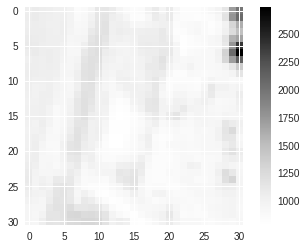

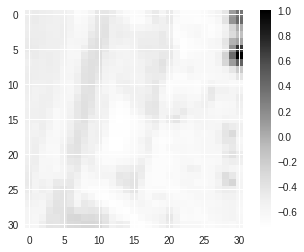

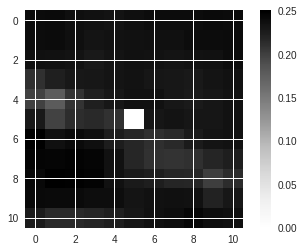

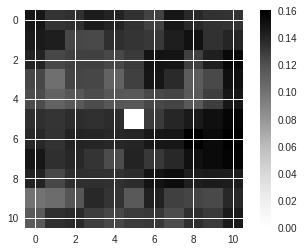

In [67]:
# plot_image(np.reshape(x_train[9291], (augmentation_size,augmentation_size)))
plot_image(np.squeeze(full_image_array[9291]))
plot_image(np.reshape(norm_x[9291], (31,31)))


plot_image(np.reshape(x_test[6], (augmentation_size,augmentation_size)))
plot_image(np.reshape(x_val[random.randrange(1,500)], (augmentation_size,augmentation_size)))

In [26]:
imageminval = np.min(np.min(np.where(full_image_array==0, full_image_array.max(), full_image_array), axis=1))

maxval = np.max(np.max(np.where(full_image_array==0, full_image_array.min(), full_image_array), axis=1))

zeroval = np.argwhere(full_image_array==0)

max_arg = np.argwhere(full_image_array==2736)

print(minval, maxval, max_arg)

# print(full_image_array[495][20]) 

487 2736 [[9291    6   30    0]]
